In [1]:
from community import community_louvain
import gc
import logging
import os
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
from scipy.optimize import differential_evolution, basinhopping
import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# import tensorflow_probability as tfp
import warnings
logger = tf.get_logger()

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
logging.basicConfig(encoding='utf-8', level=logging.INFO,
                    force = True)

In [3]:
class DnnResult():
    def __init__(self, theta, stuck):
        self.theta = theta
        self.stuck = stuck

In [4]:
def graph1_adjacency_matrix():
    return np.array([
        [0, 1, 1, 0, 0, 0, 1, 0, ],
        [1, 0, 0, 1, 0, 0, 0, 1, ],
        [1, 0, 0, 1, 1, 0, 0, 0, ],
        [0, 1, 1, 0, 0, 1, 0, 0, ],
        [0, 0, 1, 0, 0, 1, 1, 0, ],
        [0, 0, 0, 1, 1, 0, 0, 1, ],
        [1, 0, 0, 0, 1, 0, 0, 1, ],
        [0, 1, 0, 0, 0, 1, 1, 0, ],
    ])


In [5]:
def build_test_graph1():
    adj_mat = graph1_adjacency_matrix()
    N = len(adj_mat)

    G = nx.Graph()
    for i in range(N):
        G.add_node(i)

    for i in range(N):
        for j in range(N):
            if adj_mat[i][j] == 1:
                G.add_edge(i, j)
                G.add_edge(j, i)
    return G

In [6]:
def clip(l,r,x):
    return max(l,min(r,x))

def calc_W(G, C):
    n = len(G.nodes())
    m = len(G.edges())
    m_c = len(C.edges())
    W = np.zeros((n,n+m+m_c),dtype= 'float32')
    for i in range(n):
        W[i][i] = 1
    j = n
    for edge in G.edges():
        x = int(edge[0])
        y = int(edge[1])
        W[x][j] = 1
        W[y][j] = 1
        j+=1
    for edge in C.edges():
        x = int(edge[0])
        y = int(edge[1])
        W[x][j] = 1
        W[y][j] = 1
        j+=1
    return W

def calc_b(G, C):
    n = len(G.nodes())
    m = len(G.edges())
    m_c = len(C.edges())
    b = np.array([-1/2 for i in range(n)])
    b_m = np.array([-1 for i in range(m+m_c)])
    return np.concatenate((b,b_m))

def calc_w(G, C):
    n = len(G.nodes())
    m = len(G.edges())
    m_c = len(C.edges())
    w = np.array([-1 for i in range(n)])
    w_n = np.array([n for i in range(m)])
    w_c = np.array([-1 for i in range(m_c)])
    return np.concatenate((w,w_n,w_c))

def build_theta(G):
    n = len(G.nodes())
    max_degree = max([G.degree(i) for i in range(n)])
#     logging.debug("Max degree = {}".format(max_degree))
    if max_degree == 0:
        return np.array([1 for i in range(n)])
    return np.array([clip(0,1,1 - G.degree(i)/max_degree + random.random()/1000) for i in range(n)])
#     return np.array([random.random() for i in range(n)])

def build_network(G):
    logging.info("Build network on graph G:{}.".format(str(G)))
    C = nx.complement(G)
    W = calc_W(G, C)
    b = calc_b(G, C)
    w = calc_w(G, C)
    theta = build_theta(G)
#     logging.debug("Initial theta = {}".format(theta))
    return (W,b,w, theta, C)


In [9]:
def get_result_nodes(theta, alpha = 0.5):
    return set(np.argwhere(theta > alpha).reshape(-1))

def not_connected_nodes_exist_in_G(G, result_nodes):
    for v in G.nodes():
        if v not in result_nodes:
            node_not_connected_to_G = True
            for edge in G.neighbors(v):
                if edge in result_nodes:
                    node_not_connected_to_G = False
                    break
            if node_not_connected_to_G:
                return True
    return False
            
def graph_has_no_edges(G, result_nodes):
    for v in result_nodes:
        for edge in G.neighbors(v):
            if edge in result_nodes:
                return False
    return True
            
def result_is_valid(G, theta):
    result_nodes = get_result_nodes(theta)
    return graph_has_no_edges(G, result_nodes) and not not_connected_nodes_exist_in_G(G, result_nodes)
    
def network(theta,e_n,W_t,b,w_t):
        h = tf.math.multiply(e_n,theta)
        h = tf.linalg.matvec(W_t,h)
        h = tf.add(h,b)
        h = tf.nn.relu(h)
        h = tf.tensordot(w_t,h, 1)
        return h
    
def network_evol(theta,e_n,W_t,b,w_t):
    return network(theta,e_n,W_t,b,w_t).numpy()

def loss(theta,e_n,W_t,b,w_t,h_d):
    h = network(theta,e_n,W_t,b,w_t)
    return (h-h_d)**2   

def loss_evol(theta,e_n,W_t,b,w_t,h_d):
    h = network_evol(theta,e_n,W_t,b,w_t)
    return (h-h_d)**2  

def evolutionary_train(n,theta,e_n,W_t,b,w_t,h_d):
    bounds = [(0,1) for i in range(n)]
    theta = differential_evolution(loss_evol, bounds, x0 = theta, args = (e_n,W_t,b,w_t,h_d))
    theta = theta.x
    return DnnResult(theta, False)

def vectors_are_close(a,b):
    norm_diff = np.linalg.norm(a-b)
    return norm_diff < 1e-6 

def gradient_train(G, max_epochs, theta,e_n,W_t,b,w_t,h_d):
    optimizer=tf.optimizers.Adam(learning_rate=0.1,)
    epoch = 0

    def local_loss():
        return loss(theta,e_n,W_t,b,w_t,h_d)
    solver_stuck = False
    previous_theta = theta.numpy()
    while not result_is_valid(G, theta) and epoch < max_epochs and not solver_stuck:
#     while not result_is_valid(G, theta):
        logging.debug("Epoch = {}".format(epoch))
        optimizer.minimize(local_loss, var_list=[theta])
        logging.debug("theta = {}".format(theta))
        previous_error = local_loss()
    #         logging.debug("Loss = {}".format(previous_error))
        epoch+=1
        if (previous_theta == theta.numpy()).all():
            logging.info("Solver stuck")
            solver_stuck = True
#         if vectors_are_close(previous_theta,theta.numpy()):
#             logging.info("Solver approaches plateu.")
#             break
        previous_theta = theta.numpy()
    if result_is_valid(G, theta):
        logging.debug("Optimal solution found. Cardinality = {}".format(len(get_result_nodes(theta))))
        logging.info("dNN solution is correct")
    else:
        logging.info("dNN solution is not correct")
        if not_connected_nodes_exist_in_G(G, get_result_nodes(theta)):
            logging.info("Can add more nodes to IS")
        else:
            logging.info("There are extra nodes in IS")
    if epoch == max_epochs:
        logging.info("Epochs exceeded maximum")
    logging.info("Total epochs = {}".format(epoch))
    logging.info("dNN solution lenghth = {}".format(len(get_result_nodes(theta))))
    return DnnResult(theta.numpy(), solver_stuck or epoch == max_epochs)

def train_network(G, max_epochs = 100, method="gradient"):
    (W,b,w, theta, C) = build_network(G)
    n = len(G.nodes())
    W_t = tf.constant(W.T, dtype = 'float32')
    b = tf.constant(b, dtype = 'float32')
    w_t = tf.constant(w.T, dtype = 'float32')
    theta = tf.Variable(theta,
                        trainable=True,
                        constraint = lambda x: tf.clip_by_value(theta,0,1),
                        dtype = 'float32')
    e_n = tf.constant(np.ones((n)),dtype = 'float32')
    h_d = -n*n/2

    if method == "evolutionary":
        result = evolutionary_train(n,theta, e_n,W_t,b,w_t,h_d)
    elif method == "gradient":
        result = gradient_train(G, max_epochs,theta, e_n,W_t,b,w_t,h_d)
    elif method == "mixed":
        result = gradient_train(G, max_epochs,theta, e_n,W_t,b,w_t,h_d)
        if not result_is_valid(G, result.theta):
            logging.info("Gradient method did not find solution. Trying evolutionary method...")
            theta = tf.Variable(build_theta(G),
                        trainable=True,
                        dtype = 'float32')
            result = evolutionary_train(n,theta, e_n,W_t,b,w_t,h_d)
    return result

In [10]:
def graphSets(graph): # Determinative algorithm to use correctness of the solution. Works too long for graphs >= 30 nodes.
    # Base Case - Given Graph 
    # has no nodes
    if(len(graph) == 0):
        return []
     
    # Base Case - Given Graph
    # has 1 node
    if(len(graph) == 1):
        return [list(graph.keys())[0]]
      
    # Select a vertex from the graph
    vCurrent = list(graph.keys())[0]
      
    # Case 1 - Proceed removing
    # the selected vertex
    # from the Maximal Set
    graph2 = dict(graph)
      
    # Delete current vertex 
    # from the Graph
    del graph2[vCurrent]
      
    # Recursive call - Gets 
    # Maximal Set,
    # assuming current Vertex 
    # not selected
    res1 = graphSets(graph2)
      
    # Case 2 - Proceed considering
    # the selected vertex as part
    # of the Maximal Set
  
    # Loop through its neighbours
    for v in graph[vCurrent]:
          
        # Delete neighbor from 
        # the current subgraph
        if(v in graph2):
            del graph2[v]
      
    # This result set contains VFirst,
    # and the result of recursive
    # call assuming neighbors of vFirst
    # are not selected
    res2 = [vCurrent] + graphSets(graph2)
      
    # Our final result is the one 
    # which is bigger, return it
    if(len(res1) > len(res2)):
        return res1
    return res2

def calculate_recursive_broot_force_result(G, draw_graph = True):
    dict_G = nx.to_dict_of_lists(G)
    print("Recursive approach")
    MIS = graphSets(dict_G)
    print(MIS)
    print("Length = "+str(len(MIS)))
    if draw_graph:
        color_map = ['red' if node in MIS else 'blue' for node in G]
        graph = nx.draw(G, node_color=color_map) # node lables
        plt.show()

In [11]:
def calculate_determenistic_result(G, draw_graph = True):
    print("Deterministic built-in approach")
    MIS = nx.maximal_independent_set(G)
    print(MIS)
    print("Length = "+str(len(MIS)))
    if draw_graph:
        color_map = ['yellow' if node in MIS else 'blue' for node in G]
        graph = nx.draw(G, node_color=color_map,with_labels = True) # node lables
        plt.show()

In [12]:
def calculate_DNN_result(G, theta, threshold = 0.5, draw_graph = True):
    print("DNN approach")
    result_nodes = get_result_nodes(theta)
    print(result_nodes)
    print("Length = "+str(len(result_nodes)))
    if draw_graph:
        color_map = ['green' if node in result_nodes else 'blue' for node in G]        
        graph = nx.draw(G, node_color=color_map,with_labels = True) # node lables
        plt.show()
        
def calculate_DNN_result(G, MIS, draw_graph = True):
    print(MIS)
    print("Length = "+str(len(MIS)))
    if draw_graph:
        color_map = ['green' if node in MIS else 'blue' for node in G]        
        graph = nx.draw(G, node_color=color_map,with_labels = True) # node lables
        plt.show()

In [13]:
def draw_DNN_result(G, max_epochs = 100,):
    MIS = calculate_large_G(G)
    calculate_DNN_result(G, MIS, draw_graph=True)

In [14]:
def read_G_from_file(filepath):
    return nx.read_edgelist(filepath)

In [15]:
# compareResults(nx.complete_graph(10), draw_graph=False) # Expected result = 1

In [16]:
# compareResults(nx.graph_atlas(1000),draw_graph=True)

In [17]:
# compareResults(nx.gnp_random_graph(20, 0.1), 200, True) #Expected result around 12-14

In [18]:
# compareResults(nx.gnp_random_graph(50, 0.075), max_epochs = 1000)

In [19]:
# compareResults(nx.gnp_random_graph(100, 0.1), max_epochs = 1000, draw_graph=False)

In [20]:
# wiki_vote_G = read_G_from_file('datasets/Wiki-Vote.txt') 
# print(wiki_vote_G)

In [22]:
def find_inter_cluster_edges(G, communities):
    edges = dict()
    for com in communities:
        for node_i in communities[com]:
            for neighbour_i in G.neighbors(node_i):
                if neighbour_i not in communities[com]:
                    if edges.get(node_i) is not None:
                        edges[node_i].append(neighbour_i)
                    else:
                        edges[node_i] = [neighbour_i]
                    if edges.get(neighbour_i) is not None:
                        edges[neighbour_i].append(node_i)
                    else:
                        edges[neighbour_i] = [node_i]
    return edges

In [23]:
def find_forbidden_edges(G, R, independent_sets):
    forbidden = []
    for node, edges in R.items():
        if node in independent_sets:
            for edge in edges:
                if edge in independent_sets:
                    forbidden.append((node, edge))
    return forbidden

In [24]:
def collect_list_by_dicts_key(partitions):
    communities = {}
    for key, val in partitions.items():
        if communities.get(val) == None:
            communities[val] = [key]
        else:
            communities[val].append(key)
    return communities

In [25]:
def build_G_from_nodes(G, nodes):
    communities = {}
    N = len(nodes)
    new_G = nx.Graph()
    index_map = dict()
    node_map = dict()
    index = 0
    for node in nodes:
        index_map[index] = node
        node_map[node] = index
        new_G.add_node(index)
        index+=1
    for i in nodes:
        for j in nodes:
            if G.has_edge(i,j):
                new_G.add_edge(node_map[i], node_map[j])
                new_G.add_edge(node_map[j], node_map[i])
    return (new_G, index_map, node_map)

In [26]:
def node_is_new_candidate(G, node, mis):
    neighbors = G.neighbors(node)
    neighbours_in_mis_count = 0
    for w in neighbors:
        if w in mis:
            neighbours_in_mis_count += 1
            if neighbours_in_mis_count == 2:
                break
            if neighbours_in_mis_count == 1:
                return (True, w)
    return (False, -1) 

In [27]:
def get_node_with_most_occurences(F, q, v):
    count_q = 0
    count_v = 0
    for x,y in F:
        if x == q:
            count_q+=1
        if y == v:
            count_v+=1
    if count_q > v:
        return q
    else:
        return v

In [28]:
def replace_node_if_possible(G,F,mis,node):
#     if node not in mis:
#         logging.info("Node {} not in mis. Can be replaced".format(node))
#         return True
    (can_be_replaced, new_node) = node_is_new_candidate(G,node,mis)
    if can_be_replaced:
#         logging.info("Node {} can be replaced with {}".format(node, new_node))
        mis.remove(node)
        mis.add(new_node)
        return True
    return False 

In [29]:
def replace_forbiden_nodes(G,R,F,mis):
    logging.info("Replacing forbiden nodes")
    while len(F) > 0:
#         logging.info("Length of F = {}".format(len(F)))
        for q,v in F:
            replaced = replace_node_if_possible(G,F,mis,q)
            if replaced:
                break
            else:
                replaced = replace_node_if_possible(G,F,mis,v)
            if replaced:
                break
            else:
                node_to_be_removed = get_node_with_most_occurences(F,q,v)
                mis.remove(node_to_be_removed)
        F = find_forbidden_edges(G, R, mis)
    return mis

In [30]:
def build_G_from_left_nodes(G, nodes):
    mis_with_neighbours = set()
    for node in nodes:
        mis_with_neighbours.add(node)
        for neighbour in G.neighbors(node):
            mis_with_neighbours.add(neighbour)
    nodes_left_to_process = set(G.nodes()).difference(mis_with_neighbours)
    return build_G_from_nodes(G,nodes_left_to_process)

In [60]:
def calculate_mis_with_left_nodes(G, mis_list, max_epochs,method):
    (left_G, left_index_map, left_node_map)  = build_G_from_left_nodes(G, mis_list)
    logging.info("Left nodes = {}".format([left_index_map[node] for node in left_G.nodes()]))
    if len(left_G.nodes()) > 100:
        mis = calculate_large_G(left_G, max_epochs)
    elif len(left_G.nodes()) > 0:
        mis = validate_dnn_result(train_network(left_G, max_epochs,method),left_G)
    else:
        mis = {}
    mis_correct = [left_index_map[node] for node in mis]
    logging.info("mis_correct = {}".format(mis_correct))
    mis_final = mis_list.union(mis_correct)
    return mis_final

In [61]:
def build_U_from_IS(_lambda, IS,G,):
    if len(IS) == 0:
        return []
    degree_list_ascending = [(G.degree(node),node) for node in IS]
    degree_list_ascending.sort(key=lambda pair: pair[0])
    return [pair[1] for pair in degree_list_ascending[:min(_lambda, len(IS))]]

In [62]:
def validate_dnn_result(dnn_result, G):
    if True:
#     if dnn_result.stuck:
        logging.info("Solver stuck...")
        if len(G.edges()) < 50:
            logging.info("Using local search...")
            dict_G = nx.to_dict_of_lists(G)
            mis = graphSets(dict_G)
            logging.info("Local search mis length = {}".format(len(mis)))
            return mis
        else:
            logging.info("Picking any IS...")
            mis = nx.maximal_independent_set(G)
            logging.info("IS length = {}".format(len(mis)))
            return mis
    else:
        theta_for_small_G = dnn_result.theta
        return get_result_nodes(theta_for_small_G)

In [63]:
def try_remove_nodes_with_small_degree(mis, small_G, max_epochs, method):
    _lambda = 5
    while True:
        U = build_U_from_IS(_lambda, mis,small_G)
        (new_small_G,index_map, node_map) = build_G_from_left_nodes(small_G, U)
        if len(new_small_G.nodes()) < 20:
            break
        dnn_result = train_network(new_small_G, max_epochs,method)
        mis_correct = {index_map[node] for node in validate_dnn_result(dnn_result, new_small_G)}
        new_mis = mis_correct.union(mis)
        if(len(new_mis)>len(mis)):
            mis = new_mis
        _lambda+=1
    logging.info("Returning IS with length = {}".format(len(mis)))
    return mis

In [64]:
def calculate_large_G(G, max_epochs = 500, method='gradient'):
    logging.info("Calculating G with nodes = {} edges = {}".format(len(G.nodes()), len(G.edges())))
    logging.info("Density of G = {}".format(nx.density(G)))
    partitions = community_louvain.best_partition(G, resolution= 1.3)
    communities = collect_list_by_dicts_key(partitions)
    logging.info("Total communities {}".format(len(communities)))
    R = find_inter_cluster_edges(G, communities)
    mis_list = set()
    community_index = 1

    for com in communities:
        logging.info("Community {} processing...".format(community_index))
        (small_G,index_map, node_map) = build_G_from_nodes(G, communities[com])
        dnn_result = train_network(small_G, max_epochs,method)
        mis = validate_dnn_result(dnn_result, small_G)
        logging.debug("MIS length = {}".format(len(mis)))

        mis = try_remove_nodes_with_small_degree(mis, small_G,max_epochs, method)
        logging.info("MIS after removing nodes with small degrees length = {}".format(len(mis)))
        mis_correct = {index_map[node] for node in mis}
        logging.info("MIS in community = {}".format(mis_correct))
        mis_list = mis_list.union(mis_correct)
        community_index += 1
    logging.info("MIS after all communitites processed length = {}".format(len(mis_list)))
    F = find_forbidden_edges(G, R, mis_list)
    replace_forbiden_nodes(G,R,F,mis_list)
    logging.info("MIS after forbidden nodes processed length = {}".format(len(mis_list)))
    logging.info("MIS={}".format(mis_list))
    mis_list = calculate_mis_with_left_nodes(G, mis_list, max_epochs,method)
    logging.info("Total MIS length found = {}".format(len(mis_list)))
    return mis_list

In [65]:
# wiki_vote_G_MIS = calculate_large_G(wiki_vote_G, 1000)

In [66]:
def test_average_result_on_graph(G, graph_name, iterations = 5):
    sum = 0
    for i in range(iterations):
        mis = calculate_large_G(G)
        sum+=len(mis)
    print("dNN result on {} = {}".format(graph_name,sum/iterations))

In [67]:
def test_network_on_graphs(graphs, method='gradient'):
    sum = 0
    n = len(graphs)
    for i in range(n):
        mis = calculate_large_G(graphs[i], 1000,method)
        sum+=len(mis)
    print("Average dNN result = {}".format(sum/n))

In [68]:
def build_n_graphs(n, graph_func):
    return [graph_func() for i in range(n)]

INFO:root:Calculating G with nodes = 8 edges = 12
INFO:root:Density of G = 0.42857142857142855
INFO:root:Total communities 2
INFO:root:Community 1 processing...
INFO:root:Build network on graph G:Graph with 4 nodes and 4 edges.
INFO:root:Solver stuck
INFO:root:dNN solution is not correct
INFO:root:Can add more nodes to IS
INFO:root:Total epochs = 1
INFO:root:dNN solution lenghth = 0
INFO:root:Solver stuck...
INFO:root:Using local search...
INFO:root:Local search mis length = 2
INFO:root:Returning IS with length = 2
INFO:root:MIS after removing nodes with small degrees length = 2
INFO:root:MIS in community = {0, 7}
INFO:root:Community 2 processing...
INFO:root:Build network on graph G:Graph with 4 nodes and 4 edges.
INFO:root:Solver stuck
INFO:root:dNN solution is not correct
INFO:root:Can add more nodes to IS
INFO:root:Total epochs = 1
INFO:root:dNN solution lenghth = 0
INFO:root:Solver stuck...
INFO:root:Using local search...
INFO:root:Local search mis length = 2
INFO:root:Returning I

{1, 2, 5, 6}
Length = 4


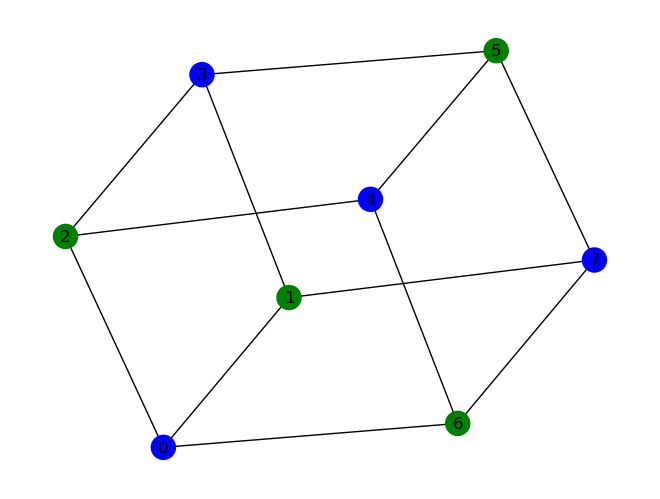

In [69]:
G = build_test_graph1()
calculate_DNN_result(G, calculate_large_G(G), True)

In [76]:
networks = build_n_graphs(1, lambda: nx.erdos_renyi_graph(100,0.1), )

In [77]:
test_network_on_graphs(networks)

INFO:root:Calculating G with nodes = 100 edges = 510
INFO:root:Density of G = 0.10303030303030303
INFO:root:Total communities 3
INFO:root:Community 1 processing...
INFO:root:Build network on graph G:Graph with 25 nodes and 63 edges.
INFO:root:dNN solution is correct
INFO:root:Total epochs = 52
INFO:root:dNN solution lenghth = 10
INFO:root:Solver stuck...
INFO:root:Picking any IS...
INFO:root:IS length = 8
INFO:root:Returning IS with length = 8
INFO:root:MIS after removing nodes with small degrees length = 8
INFO:root:MIS in community = {65, 39, 72, 10, 81, 53, 92, 62}
INFO:root:Community 2 processing...
INFO:root:Build network on graph G:Graph with 39 nodes and 119 edges.
INFO:root:Solver stuck
INFO:root:dNN solution is not correct
INFO:root:Can add more nodes to IS
INFO:root:Total epochs = 98
INFO:root:dNN solution lenghth = 11
INFO:root:Solver stuck...
INFO:root:Picking any IS...
INFO:root:IS length = 9
INFO:root:Returning IS with length = 9
INFO:root:MIS after removing nodes with sm

Average dNN result = 23.0


In [549]:
networks = build_n_graphs(10, lambda: nx.erdos_renyi_graph(100,0.2), )

In [550]:
test_network_on_graphs(networks)

INFO:root:Calculating G with nodes = 100 edges = 984
INFO:root:Density of G = 0.1987878787878788
INFO:root:Total communities 2
INFO:root:Community 1 processing...
INFO:root:Build network on graph G:Graph with 42 nodes and 232 edges.
INFO:root:Solver stuck
INFO:root:dNN solution is not correct
INFO:root:Can add more nodes to IS
INFO:root:Total epochs = 174
INFO:root:dNN solution lenghth = 0
INFO:root:Solver stuck...
INFO:root:Picking any IS...
INFO:root:IS length = 9
INFO:root:Returning IS with length = 9
INFO:root:MIS after removing nodes with small degrees length = 9
INFO:root:MIS in community = {66, 8, 47, 80, 49, 17, 86, 89, 61}
INFO:root:Community 2 processing...
INFO:root:Calculating G with nodes = 58 edges = 400
INFO:root:Density of G = 0.24198427102238354
INFO:root:Total communities 3
INFO:root:Community 1 processing...
INFO:root:Build network on graph G:Graph with 33 nodes and 154 edges.
INFO:root:Solver stuck
INFO:root:dNN solution is not correct
INFO:root:Can add more nodes t

INFO:root:Left nodes = [64, 33, 96, 3, 4, 69, 16, 18, 19, 52, 91, 92, 61, 63]
INFO:root:Build network on graph G:Graph with 14 nodes and 15 edges.
INFO:root:dNN solution is not correct
INFO:root:Can add more nodes to IS
INFO:root:Epochs exceeded maximum
INFO:root:Total epochs = 1000
INFO:root:dNN solution lenghth = 1
INFO:root:Solver stuck...
INFO:root:Using local search...
INFO:root:Local search mis length = 7
INFO:root:Left nodes IS result = [0, 2, 3, 4, 5, 6, 9]
INFO:root:mis_correct = [64, 96, 3, 4, 69, 16, 52]
INFO:root:Total MIS length found = 14
INFO:root:Calculating G with nodes = 100 edges = 972
INFO:root:Density of G = 0.19636363636363635
INFO:root:Total communities 2
INFO:root:Community 1 processing...
INFO:root:Calculating G with nodes = 54 edges = 344
INFO:root:Density of G = 0.24039133473095736
INFO:root:Total communities 2
INFO:root:Community 1 processing...
INFO:root:Build network on graph G:Graph with 33 nodes and 166 edges.
INFO:root:Solver stuck
INFO:root:dNN solutio

INFO:root:Density of G = 0.19777777777777777
INFO:root:Total communities 2
INFO:root:Community 1 processing...
INFO:root:Calculating G with nodes = 69 edges = 526
INFO:root:Density of G = 0.22421142369991476
INFO:root:Total communities 3
INFO:root:Community 1 processing...
INFO:root:Build network on graph G:Graph with 26 nodes and 104 edges.
INFO:root:Solver stuck
INFO:root:dNN solution is not correct
INFO:root:Can add more nodes to IS
INFO:root:Total epochs = 174
INFO:root:dNN solution lenghth = 0
INFO:root:Solver stuck...
INFO:root:Picking any IS...
INFO:root:IS length = 6
INFO:root:Returning IS with length = 6
INFO:root:MIS after removing nodes with small degrees length = 6
INFO:root:MIS in community = {2, 68, 5, 52, 22, 31}
INFO:root:Community 2 processing...
INFO:root:Build network on graph G:Graph with 28 nodes and 116 edges.
INFO:root:Solver stuck
INFO:root:dNN solution is not correct
INFO:root:Can add more nodes to IS
INFO:root:Total epochs = 163
INFO:root:dNN solution lenghth 

INFO:root:Density of G = 0.24605493863237873
INFO:root:Total communities 2
INFO:root:Community 1 processing...
INFO:root:Build network on graph G:Graph with 35 nodes and 177 edges.
INFO:root:Solver stuck
INFO:root:dNN solution is not correct
INFO:root:Can add more nodes to IS
INFO:root:Total epochs = 189
INFO:root:dNN solution lenghth = 0
INFO:root:Solver stuck...
INFO:root:Picking any IS...
INFO:root:IS length = 5
INFO:root:Returning IS with length = 5
INFO:root:MIS after removing nodes with small degrees length = 5
INFO:root:MIS in community = {36, 50, 51, 26, 29}
INFO:root:Community 2 processing...
INFO:root:Build network on graph G:Graph with 24 nodes and 98 edges.
INFO:root:Solver stuck
INFO:root:dNN solution is not correct
INFO:root:Can add more nodes to IS
INFO:root:Total epochs = 177
INFO:root:dNN solution lenghth = 0
INFO:root:Solver stuck...
INFO:root:Picking any IS...
INFO:root:IS length = 7
INFO:root:Returning IS with length = 7
INFO:root:MIS after removing nodes with small

INFO:root:Epochs exceeded maximum
INFO:root:Total epochs = 1000
INFO:root:dNN solution lenghth = 1
INFO:root:Solver stuck...
INFO:root:Picking any IS...
INFO:root:IS length = 7
INFO:root:Build network on graph G:Graph with 24 nodes and 62 edges.
INFO:root:Solver stuck
INFO:root:dNN solution is not correct
INFO:root:Can add more nodes to IS
INFO:root:Total epochs = 183
INFO:root:dNN solution lenghth = 0
INFO:root:Solver stuck...
INFO:root:Picking any IS...
INFO:root:IS length = 6
INFO:root:Returning IS with length = 19
INFO:root:MIS after removing nodes with small degrees length = 19
INFO:root:MIS in community = {0, 4, 5, 6, 8, 13, 17, 23, 24, 42, 44, 49, 61, 68, 83, 93, 96, 97, 99}
INFO:root:Community 2 processing...
INFO:root:Build network on graph G:Graph with 30 nodes and 137 edges.
INFO:root:Solver stuck
INFO:root:dNN solution is not correct
INFO:root:Can add more nodes to IS
INFO:root:Total epochs = 174
INFO:root:dNN solution lenghth = 0
INFO:root:Solver stuck...
INFO:root:Picking

INFO:root:Solver stuck...
INFO:root:Picking any IS...
INFO:root:IS length = 7
INFO:root:Build network on graph G:Graph with 26 nodes and 91 edges.
INFO:root:Solver stuck
INFO:root:dNN solution is not correct
INFO:root:Can add more nodes to IS
INFO:root:Total epochs = 183
INFO:root:dNN solution lenghth = 0
INFO:root:Solver stuck...
INFO:root:Picking any IS...
INFO:root:IS length = 8
INFO:root:Build network on graph G:Graph with 20 nodes and 51 edges.
INFO:root:Solver stuck
INFO:root:dNN solution is not correct
INFO:root:Can add more nodes to IS
INFO:root:Total epochs = 177
INFO:root:dNN solution lenghth = 0
INFO:root:Solver stuck...
INFO:root:Picking any IS...
INFO:root:IS length = 6
INFO:root:Returning IS with length = 40
INFO:root:MIS after removing nodes with small degrees length = 40
INFO:root:MIS in community = {1, 2, 3, 4, 7, 8, 10, 12, 14, 18, 22, 26, 28, 29, 30, 33, 38, 40, 41, 42, 43, 46, 48, 49, 54, 55, 57, 60, 63, 64, 69, 70, 78, 79, 83, 89, 91, 93, 95, 96}
INFO:root:MIS afte

Average dNN result = 19.5


In [555]:
test_average_result_on_graph(nx.erdos_renyi_graph(200,0.1),"ER 200, 0.1", 5)

INFO:root:Calculating G with nodes = 200 edges = 1942
INFO:root:Density of G = 0.09758793969849246
INFO:root:Total communities 2
INFO:root:Community 1 processing...
INFO:root:Calculating G with nodes = 82 edges = 454
INFO:root:Density of G = 0.13670581150255948
INFO:root:Total communities 4
INFO:root:Community 1 processing...
INFO:root:Build network on graph G:Graph with 30 nodes and 110 edges.
INFO:root:Solver stuck
INFO:root:dNN solution is not correct
INFO:root:Can add more nodes to IS
INFO:root:Total epochs = 183
INFO:root:dNN solution lenghth = 0
INFO:root:Solver stuck...
INFO:root:Picking any IS...
INFO:root:IS length = 8
INFO:root:Returning IS with length = 8
INFO:root:MIS after removing nodes with small degrees length = 8
INFO:root:MIS in community = {0, 70, 7, 8, 73, 80, 49, 63}
INFO:root:Community 2 processing...
INFO:root:Build network on graph G:Graph with 25 nodes and 68 edges.
INFO:root:Solver stuck
INFO:root:dNN solution is not correct
INFO:root:Can add more nodes to IS


INFO:root:Using local search...
INFO:root:Local search mis length = 6
INFO:root:Left nodes IS result = [0, 1, 2, 3, 8, 9]
INFO:root:mis_correct = [0, 9, 41, 43, 24, 25]
INFO:root:Total MIS length found = 14
INFO:root:Build network on graph G:Graph with 25 nodes and 63 edges.
INFO:root:Solver stuck
INFO:root:dNN solution is not correct
INFO:root:Can add more nodes to IS
INFO:root:Total epochs = 195
INFO:root:dNN solution lenghth = 0
INFO:root:Solver stuck...
INFO:root:Picking any IS...
INFO:root:IS length = 10
INFO:root:Build network on graph G:Graph with 21 nodes and 46 edges.
INFO:root:Solver stuck
INFO:root:dNN solution is not correct
INFO:root:Can add more nodes to IS
INFO:root:Total epochs = 164
INFO:root:dNN solution lenghth = 0
INFO:root:Solver stuck...
INFO:root:Using local search...
INFO:root:Local search mis length = 9
INFO:root:Returning IS with length = 20
INFO:root:MIS after removing nodes with small degrees length = 20
INFO:root:MIS in community = {0, 10, 19, 23, 24, 27, 2

INFO:root:Solver stuck...
INFO:root:Picking any IS...
INFO:root:IS length = 12
INFO:root:Returning IS with length = 12
INFO:root:MIS after removing nodes with small degrees length = 12
INFO:root:MIS in community = {0, 97, 138, 107, 109, 142, 111, 13, 17, 180, 21, 154}
INFO:root:Community 2 processing...
INFO:root:Calculating G with nodes = 94 edges = 546
INFO:root:Density of G = 0.12491420727522307
INFO:root:Total communities 3
INFO:root:Community 1 processing...
INFO:root:Build network on graph G:Graph with 15 nodes and 35 edges.
INFO:root:Solver stuck
INFO:root:dNN solution is not correct
INFO:root:Can add more nodes to IS
INFO:root:Total epochs = 162
INFO:root:dNN solution lenghth = 0
INFO:root:Solver stuck...
INFO:root:Using local search...
INFO:root:Local search mis length = 5
INFO:root:Returning IS with length = 5
INFO:root:MIS after removing nodes with small degrees length = 5
INFO:root:MIS in community = {0, 10, 42, 76, 47}
INFO:root:Community 2 processing...
INFO:root:Build ne

INFO:root:IS length = 8
INFO:root:Returning IS with length = 8
INFO:root:MIS after removing nodes with small degrees length = 8
INFO:root:MIS in community = {32, 37, 43, 45, 18, 24, 61, 63}
INFO:root:MIS after all communitites processed length = 23
INFO:root:Replacing forbiden nodes
INFO:root:MIS after forbidden nodes processed length = 7
INFO:root:MIS={2, 9, 18, 37, 43, 50, 63}
INFO:root:Left nodes = [1, 3, 4, 5, 15, 17, 19, 21, 22, 29, 31, 34, 38, 40, 46, 48, 52, 57, 60, 62, 65]
INFO:root:Build network on graph G:Graph with 21 nodes and 44 edges.
INFO:root:dNN solution is not correct
INFO:root:Can add more nodes to IS
INFO:root:Epochs exceeded maximum
INFO:root:Total epochs = 500
INFO:root:dNN solution lenghth = 1
INFO:root:Solver stuck...
INFO:root:Using local search...
INFO:root:Local search mis length = 10
INFO:root:Left nodes IS result = [0, 1, 2, 3, 4, 8, 10, 11, 13, 14]
INFO:root:mis_correct = [1, 3, 4, 5, 15, 22, 31, 34, 40, 46]
INFO:root:Total MIS length found = 17
INFO:root:

INFO:root:Using local search...
INFO:root:Local search mis length = 5
INFO:root:Returning IS with length = 5
INFO:root:MIS after removing nodes with small degrees length = 5
INFO:root:MIS in community = {5, 14, 19, 55, 59}
INFO:root:MIS after all communitites processed length = 19
INFO:root:Replacing forbiden nodes
INFO:root:MIS after forbidden nodes processed length = 8
INFO:root:MIS={5, 7, 9, 25, 26, 44, 50, 53}
INFO:root:Left nodes = [0, 32, 2, 33, 37, 39, 8, 40, 49, 20, 58]
INFO:root:Build network on graph G:Graph with 11 nodes and 8 edges.
INFO:root:dNN solution is not correct
INFO:root:Can add more nodes to IS
INFO:root:Epochs exceeded maximum
INFO:root:Total epochs = 500
INFO:root:dNN solution lenghth = 4
INFO:root:Solver stuck...
INFO:root:Using local search...
INFO:root:Local search mis length = 7
INFO:root:Left nodes IS result = [1, 2, 4, 5, 6, 9, 10]
INFO:root:mis_correct = [32, 2, 37, 39, 8, 20, 58]
INFO:root:Total MIS length found = 15
INFO:root:Build network on graph G:Gr

INFO:root:Solver stuck...
INFO:root:Using local search...
INFO:root:Local search mis length = 11
INFO:root:Build network on graph G:Graph with 21 nodes and 35 edges.
INFO:root:dNN solution is not correct
INFO:root:Can add more nodes to IS
INFO:root:Epochs exceeded maximum
INFO:root:Total epochs = 500
INFO:root:dNN solution lenghth = 2
INFO:root:Solver stuck...
INFO:root:Using local search...
INFO:root:Local search mis length = 10
INFO:root:Returning IS with length = 53
INFO:root:MIS after removing nodes with small degrees length = 53
INFO:root:MIS in community = {3, 132, 7, 9, 10, 11, 12, 13, 138, 142, 143, 19, 149, 22, 24, 156, 161, 164, 39, 42, 170, 44, 173, 47, 48, 49, 175, 177, 54, 55, 184, 187, 189, 63, 65, 66, 68, 197, 72, 75, 77, 78, 81, 83, 88, 89, 93, 95, 108, 114, 116, 117, 124}
INFO:root:MIS after all communitites processed length = 107
INFO:root:Replacing forbiden nodes
INFO:root:MIS after forbidden nodes processed length = 22
INFO:root:MIS={16, 47, 63, 66, 72, 75, 78, 88, 

INFO:root:Solver stuck...
INFO:root:Picking any IS...
INFO:root:IS length = 7
INFO:root:Returning IS with length = 7
INFO:root:MIS after removing nodes with small degrees length = 7
INFO:root:MIS in community = {2, 6, 79, 113, 114, 118, 123}
INFO:root:Community 4 processing...
INFO:root:Build network on graph G:Graph with 29 nodes and 94 edges.
INFO:root:Solver stuck
INFO:root:dNN solution is not correct
INFO:root:Can add more nodes to IS
INFO:root:Total epochs = 190
INFO:root:dNN solution lenghth = 0
INFO:root:Solver stuck...
INFO:root:Picking any IS...
INFO:root:IS length = 9
INFO:root:Returning IS with length = 9
INFO:root:MIS after removing nodes with small degrees length = 9
INFO:root:MIS in community = {98, 99, 100, 5, 69, 106, 52, 21, 95}
INFO:root:MIS after all communitites processed length = 34
INFO:root:Replacing forbiden nodes
INFO:root:MIS after forbidden nodes processed length = 15
INFO:root:MIS={66, 6, 5, 69, 77, 79, 81, 35, 101, 100, 46, 113, 52, 118, 123}
INFO:root:Left

INFO:root:Community 2 processing...
INFO:root:Build network on graph G:Graph with 15 nodes and 33 edges.
INFO:root:Solver stuck
INFO:root:dNN solution is not correct
INFO:root:Can add more nodes to IS
INFO:root:Total epochs = 180
INFO:root:dNN solution lenghth = 0
INFO:root:Solver stuck...
INFO:root:Using local search...
INFO:root:Local search mis length = 6
INFO:root:Returning IS with length = 6
INFO:root:MIS after removing nodes with small degrees length = 6
INFO:root:MIS in community = {2, 8, 11, 55, 26, 63}
INFO:root:Community 3 processing...
INFO:root:Build network on graph G:Graph with 32 nodes and 109 edges.
INFO:root:Solver stuck
INFO:root:dNN solution is not correct
INFO:root:Can add more nodes to IS
INFO:root:Total epochs = 201
INFO:root:dNN solution lenghth = 0
INFO:root:Solver stuck...
INFO:root:Picking any IS...
INFO:root:IS length = 8
INFO:root:Returning IS with length = 8
INFO:root:MIS after removing nodes with small degrees length = 8
INFO:root:MIS in community = {32, 6

INFO:root:Left nodes = [33, 130, 35, 5, 38, 39, 9, 42, 75, 76, 14, 113, 51, 21, 88, 122, 91, 124]
INFO:root:Build network on graph G:Graph with 18 nodes and 20 edges.
INFO:root:dNN solution is not correct
INFO:root:Can add more nodes to IS
INFO:root:Epochs exceeded maximum
INFO:root:Total epochs = 500
INFO:root:dNN solution lenghth = 2
INFO:root:Solver stuck...
INFO:root:Using local search...
INFO:root:Local search mis length = 10
INFO:root:Left nodes IS result = [1, 2, 3, 4, 5, 8, 9, 13, 14, 16]
INFO:root:mis_correct = [130, 35, 5, 38, 39, 75, 76, 21, 88, 91]
INFO:root:Total MIS length found = 28
INFO:root:Build network on graph G:Graph with 88 nodes and 443 edges.
INFO:root:Solver stuck
INFO:root:dNN solution is not correct
INFO:root:Can add more nodes to IS
INFO:root:Total epochs = 241
INFO:root:dNN solution lenghth = 0
INFO:root:Solver stuck...
INFO:root:Picking any IS...
INFO:root:IS length = 19
INFO:root:Build network on graph G:Graph with 80 nodes and 361 edges.
INFO:root:Solver

dNN result on ER 200, 0.1 = 37.2


In [558]:
test_average_result_on_graph(nx.erdos_renyi_graph(200,0.2),"ER 200, 0.2", 5)

INFO:root:Calculating G with nodes = 200 edges = 3976
INFO:root:Density of G = 0.19979899497487438
INFO:root:Total communities 1
INFO:root:Community 1 processing...
INFO:root:Build network on graph G:Graph with 200 nodes and 3976 edges.
INFO:root:Solver stuck
INFO:root:dNN solution is not correct
INFO:root:Can add more nodes to IS
INFO:root:Total epochs = 211
INFO:root:dNN solution lenghth = 0
INFO:root:Solver stuck...
INFO:root:Picking any IS...
INFO:root:IS length = 19
INFO:root:Build network on graph G:Graph with 81 nodes and 645 edges.
INFO:root:Solver stuck
INFO:root:dNN solution is not correct
INFO:root:Can add more nodes to IS
INFO:root:Total epochs = 221
INFO:root:dNN solution lenghth = 0
INFO:root:Solver stuck...
INFO:root:Picking any IS...
INFO:root:IS length = 13
INFO:root:Build network on graph G:Graph with 64 nodes and 401 edges.
INFO:root:Solver stuck
INFO:root:dNN solution is not correct
INFO:root:Can add more nodes to IS
INFO:root:Total epochs = 175
INFO:root:dNN soluti

INFO:root:Left nodes = []
INFO:root:Left nodes IS result = {}
INFO:root:mis_correct = []
INFO:root:Total MIS length found = 59
INFO:root:Calculating G with nodes = 200 edges = 3976
INFO:root:Density of G = 0.19979899497487438
INFO:root:Total communities 1
INFO:root:Community 1 processing...
INFO:root:Build network on graph G:Graph with 200 nodes and 3976 edges.
INFO:root:Solver stuck
INFO:root:dNN solution is not correct
INFO:root:Can add more nodes to IS
INFO:root:Total epochs = 204
INFO:root:dNN solution lenghth = 0
INFO:root:Solver stuck...
INFO:root:Picking any IS...
INFO:root:IS length = 19
INFO:root:Build network on graph G:Graph with 93 nodes and 894 edges.
INFO:root:Solver stuck
INFO:root:dNN solution is not correct
INFO:root:Can add more nodes to IS
INFO:root:Total epochs = 209
INFO:root:dNN solution lenghth = 0
INFO:root:Solver stuck...
INFO:root:Picking any IS...
INFO:root:IS length = 14
INFO:root:Build network on graph G:Graph with 74 nodes and 565 edges.
INFO:root:Solver s

INFO:root:mis_correct = []
INFO:root:Total MIS length found = 59
INFO:root:Calculating G with nodes = 200 edges = 3976
INFO:root:Density of G = 0.19979899497487438
INFO:root:Total communities 1
INFO:root:Community 1 processing...
INFO:root:Build network on graph G:Graph with 200 nodes and 3976 edges.
INFO:root:Solver stuck
INFO:root:dNN solution is not correct
INFO:root:Can add more nodes to IS
INFO:root:Total epochs = 211
INFO:root:dNN solution lenghth = 0
INFO:root:Solver stuck...
INFO:root:Picking any IS...
INFO:root:IS length = 20
INFO:root:Build network on graph G:Graph with 89 nodes and 796 edges.
INFO:root:Solver stuck
INFO:root:dNN solution is not correct
INFO:root:Can add more nodes to IS
INFO:root:Total epochs = 195
INFO:root:dNN solution lenghth = 0
INFO:root:Solver stuck...
INFO:root:Picking any IS...
INFO:root:IS length = 17
INFO:root:Build network on graph G:Graph with 74 nodes and 540 edges.
INFO:root:Solver stuck
INFO:root:dNN solution is not correct
INFO:root:Can add m

dNN result on ER 200, 0.2 = 60.8


In [ ]:
test_average_result_on_graph(nx.stochastic_block_model([250],[[0.1]]),"SBM 250, 0.1")

INFO:root:Calculating G with nodes = 250 edges = 3094
INFO:root:Density of G = 0.09940562248995984
INFO:root:Total communities 2
INFO:root:Community 1 processing...
INFO:root:Build network on graph G:Graph with 87 nodes and 553 edges.
INFO:root:Solver stuck
INFO:root:dNN solution is not correct
INFO:root:Can add more nodes to IS
INFO:root:Total epochs = 189
INFO:root:dNN solution lenghth = 0
INFO:root:Solver stuck...
INFO:root:Picking any IS...
INFO:root:IS length = 14
INFO:root:Build network on graph G:Graph with 42 nodes and 136 edges.
INFO:root:Solver stuck
INFO:root:dNN solution is not correct
INFO:root:Can add more nodes to IS
INFO:root:Total epochs = 221
INFO:root:dNN solution lenghth = 0
INFO:root:Solver stuck...
INFO:root:Picking any IS...
INFO:root:IS length = 10
INFO:root:Build network on graph G:Graph with 43 nodes and 168 edges.
INFO:root:Solver stuck
INFO:root:dNN solution is not correct
INFO:root:Can add more nodes to IS
INFO:root:Total epochs = 196
INFO:root:dNN solution

INFO:root:MIS after all communitites processed length = 133
INFO:root:Replacing forbiden nodes
INFO:root:MIS after forbidden nodes processed length = 35
INFO:root:MIS={24, 44, 71, 92, 109, 115, 116, 117, 120, 139, 142, 143, 144, 153, 157, 160, 168, 177, 183, 184, 188, 189, 197, 199, 207, 210, 214, 221, 226, 233, 235, 237, 245, 246, 247}
INFO:root:Left nodes = [33, 140, 204, 21, 124, 125, 127]
INFO:root:Build network on graph G:Graph with 7 nodes and 4 edges.
INFO:root:Solver stuck
INFO:root:dNN solution is not correct
INFO:root:Can add more nodes to IS
INFO:root:Total epochs = 376
INFO:root:dNN solution lenghth = 3
INFO:root:Solver stuck...
INFO:root:Using local search...
INFO:root:Local search mis length = 4
INFO:root:Left nodes IS result = [0, 1, 2, 4]
INFO:root:mis_correct = [33, 140, 204, 124]
INFO:root:Total MIS length found = 39
INFO:root:Calculating G with nodes = 250 edges = 3094
INFO:root:Density of G = 0.09940562248995984
INFO:root:Total communities 2
INFO:root:Community 1 pr

INFO:root:Can add more nodes to IS
INFO:root:Total epochs = 178
INFO:root:dNN solution lenghth = 0
INFO:root:Solver stuck...
INFO:root:Picking any IS...
INFO:root:IS length = 9
INFO:root:Build network on graph G:Graph with 27 nodes and 56 edges.
INFO:root:dNN solution is not correct
INFO:root:Can add more nodes to IS
INFO:root:Epochs exceeded maximum
INFO:root:Total epochs = 500
INFO:root:dNN solution lenghth = 1
INFO:root:Solver stuck...
INFO:root:Picking any IS...
INFO:root:IS length = 10
INFO:root:Build network on graph G:Graph with 21 nodes and 32 edges.
INFO:root:dNN solution is not correct
INFO:root:Can add more nodes to IS
INFO:root:Epochs exceeded maximum
INFO:root:Total epochs = 500
INFO:root:dNN solution lenghth = 1
INFO:root:Solver stuck...
INFO:root:Using local search...
INFO:root:Local search mis length = 11
INFO:root:Returning IS with length = 48
INFO:root:MIS after removing nodes with small degrees length = 48
INFO:root:MIS in community = {2, 4, 133, 135, 10, 11, 138, 14

In [ ]:
test_average_result_on_graph(nx.stochastic_block_model([250],[[0.2]]),"SBM 250, 0.2")

In [ ]:
test_average_result_on_graph(nx.stochastic_block_model([350],[[0.1]]),"SBM 350, 0.1")

In [ ]:
test_average_result_on_graph(nx.stochastic_block_model([350],[[0.2]]),"SBM 350, 0.2")

In [ ]:
test_average_result_on_graph(nx.barabasi_albert_graph(100,50),"BA 100")

In [ ]:
test_average_result_on_graph(nx.barabasi_albert_graph(200,90),"BA 200")

In [ ]:
test_average_result_on_graph(nx.powerlaw_cluster_graph(100,30,0.5),"HK 100")

In [ ]:
test_average_result_on_graph(nx.powerlaw_cluster_graph(200,60,0.5),"HK 200", 3)